# Salary Predictions based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Given some dataset about job postings with salaries, use this dataset to predict the missing salaries of the unseen job postings. This might be useful for the websites showing job postings to give a better estimate of the salaries for the various job postings and to give job seekers an idea about the salaries based on their credentials.

In [1]:
# import your libraries
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# some plot formatting options
sns.set_style('whitegrid')
sns.set_palette('deep')

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

#your info here
__author__ = "Lakshya Malhotra"
__email__ = "lakshya9009@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----
After loading the train data,  join the dataframes corresponding to the `train_features.csv` and `train_salaries.csv` files so as to create a single `train_df` dataframe. Load the `test_features.csv` file into a pandas dataframe as well.

In [2]:
# load the data into a Pandas dataframe
path = 'data/'
train_features = pd.read_csv(os.path.join(path, 'train_features.csv'))
train_targets = pd.read_csv(os.path.join(path, 'train_salaries.csv'))

In [3]:
# checking out first 5 rows of both dataframes
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_targets.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
# check if both train features and train targets have equal number of rows
features_jobId = set(train_features['jobId'].values)
target_jobId = set(train_targets['jobId'].values)
assert len(features_jobId.intersection(target_jobId)) == len(train_features)

In [6]:
# join train features and targets dataframe
train_df = train_features.set_index(
    'jobId').join(
    train_targets.set_index('jobId')
).reset_index()
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [7]:
# delete original dataframes to save memory
del train_features
del train_targets

In [8]:
# load the test dataframe as well
test_df = pd.read_csv(os.path.join(path, 'test_features.csv'))
test_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### ---- 3 Clean the data ----
Various Steps used for data cleaning:
- Check for duplicate data
- Check for missing data (`NaN` values)
- Check for invalid data (where salaries are negative)

We will process them by either imputing them or completely removing them depending on the quantity of such data.

In [9]:
# checking the data types for various columns and null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


It looks like there are no null-values in either train or test dataframe. Also, other than columns `yearsExperience`, `milesFromMetropolis` and the target column, all other columns are categorical.

In [11]:
# look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
print(f'There are {train_df.duplicated().sum()} duplicate rows in the train dataframe.')
print(f'There are {test_df.duplicated().sum()} duplicate rows in the test dataframe.')

There are 0 duplicate rows in the train dataframe.
There are 0 duplicate rows in the test dataframe.


In [12]:
# check for the rows with invalid salaries
train_df[train_df.salary <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


It looks like there are 5 rows where the salary is 0. These rows are not going to be useful for analysis and modelling, so we will get rid off them.

In [13]:
# removing the rows with zero salary
train_df = train_df[~(train_df.salary <= 0)]
train_df.shape

(999995, 9)

### ---- 4 Explore the data (EDA) ----

In [14]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [15]:
# analyze numerical and categorical columns separately
train_df.describe(include=[np.number])

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [16]:
train_df.describe(include=['O'])

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684954170,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


### Target Variable: `Salary`

In [17]:
# function to plot the features
def plot_features(df, feature=None, kde=False):
    """
    Help from: https://www.pythoncharts.com/2019/05/17/rotating-axis-labels/
    """
    # check whether the column is numeric
    if (df[feature].dtype.kind in ['i', 'f']):
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        fig.subplots_adjust(wspace=0.2)
        ax[0].plot(df[feature].value_counts().sort_index(), '.-', lw=2)
        ax[0].set_xlabel(feature, fontsize=16)
        ax[0].set_ylabel('count', fontsize=16)

        # show the association of the feature with the target column
        mean = df.groupby([feature])['salary'].mean()
        std = df.groupby([feature])['salary'].std()
        ax[1].plot(mean, lw=2)
        ax[1].fill_between(range(len(mean.index)), y1=(mean.values-std.values), 
                           y2=(mean.values+std.values), 
                           color='blue', alpha=0.15)
        ax[1].set_xlabel(feature, fontsize=16)
        ax[1].set_ylabel('salary', fontsize=16)
    elif (df[feature].dtype == 'object') and feature != 'companyId':
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        fig.subplots_adjust(wspace=0.2)
        plt.setp(ax[0].get_xticklabels() + ax[1].get_xticklabels(), 
                 rotation=30, ha='right')
        data = df[feature].value_counts()
        x = data.index
        y = data.values
        sns.barplot(x=x, y=y, ec='k', alpha=0.6, ax=ax[0])
        ax[0].set_xlabel(feature, fontsize=16)
        ax[0].set_ylabel('count', fontsize=16)
        
        # show the variation of the data with target column
        sns.boxplot(x=feature, y='salary', data=df, 
                    width=0.7, showmeans=True, 
                    boxprops=dict(alpha=0.6), ax=ax[1], 
                    meanprops={"marker":"o", 
                               "markerfacecolor":"gray", 
                               "markeredgecolor":"black"})
        ax[1].set_xlabel(feature, fontsize=16)
        ax[1].set_ylabel('salary', fontsize=16)
    else:
        fig, ax = plt.subplots(figsize=(14, 6))
        plt.setp(ax.get_xticklabels(), rotation=60, ha='center', fontsize=10)
        median = df.groupby([feature])['salary'].median()
        ax.scatter(median.index, median.values, c='blue', s=20, alpha=0.6)
        ax.set_xlabel(feature, fontsize=16)
        ax.set_ylabel('salary', fontsize=16)
    plt.suptitle(f'Median salary for each company', fontsize=18)
    return plt.show()        

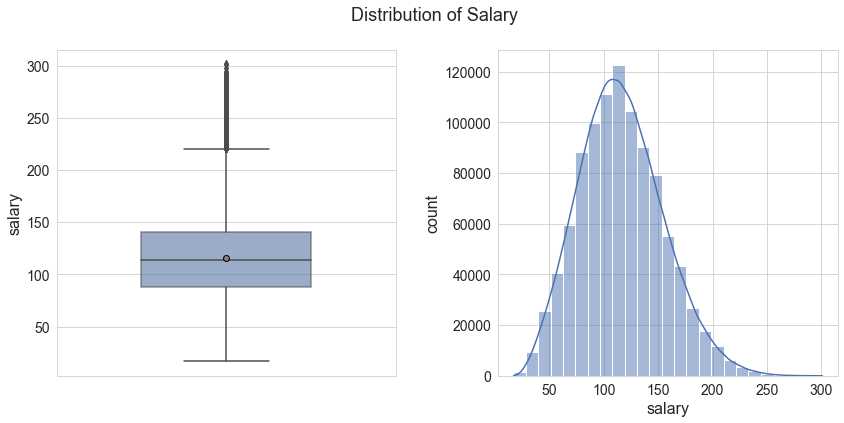

In [18]:
# plot `salary`
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)
sns.boxplot(y='salary', data=train_df, ax=ax[0], showmeans=True,
            boxprops=dict(alpha=0.6), width=0.5,
            meanprops={"marker":"o", "markerfacecolor":"gray", "markeredgecolor":"black"})
ax[0].set_ylabel('salary', fontsize=16)

# show the histogram for salary
sns.histplot(x='salary', data=train_df, kde=True, bins=25, ax=ax[1])
ax[1].set_xlabel('salary', fontsize=16)
ax[1].set_ylabel('count', fontsize=16)
plt.suptitle(f'Distribution of Salary', fontsize=18)
plt.show()

As we can see, salary is slightly right skewed which should not be surprising since there are only a handful of people with very high salaries in a typical salary distribution. Most of the salaries are located in around the range 85-140 with the median value of about 115. Also, the mean and the median values are almost coinciding meaning the distribution is almost symmetrical.

Let's check other features as well, since there are only 8 different features we can explore each one of them. We will start with numeric columns.

### Numeric Features

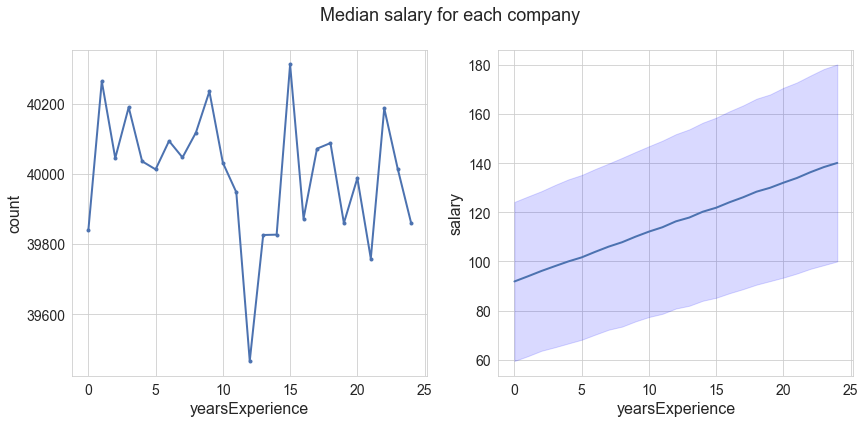

In [19]:
# plot `yearsExperience`
plot_features(train_df, 'yearsExperience')

__Clearly `yearsExperience` has a high positive correlation with the `salary`. Meaning `salary` increases with the increase in the experience.__

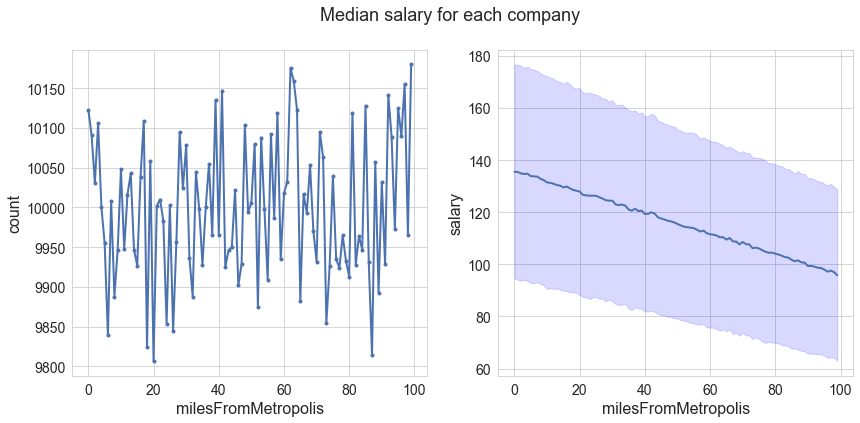

In [20]:
# plot `milesFromMetropolis`
plot_features(train_df, 'milesFromMetropolis')

__`milesFromMetropolis` varies inversely with the `salary`.__

### Categorical Variables

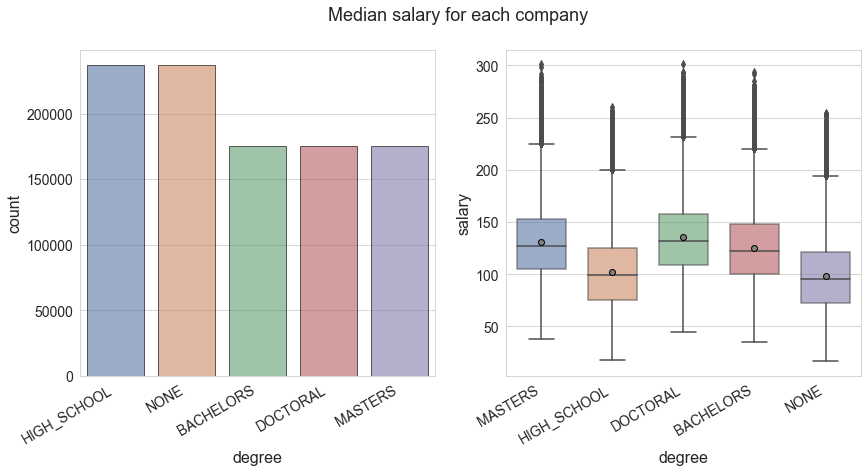

In [21]:
# plot `degree`
plot_features(train_df, 'degree')

In [22]:
train_df.groupby(['degree'])['salary'].agg(['mean', 'count']).reset_index()

,degree,mean,count
0,BACHELORS,125.454663,175495
1,DOCTORAL,135.490979,175362
2,HIGH_SCHOOL,101.921085,236975
3,MASTERS,130.505647,175310
4,NONE,98.176882,236853


__Advanced degrees such as masters and Ph.D. indeed help in getting big salaries.__

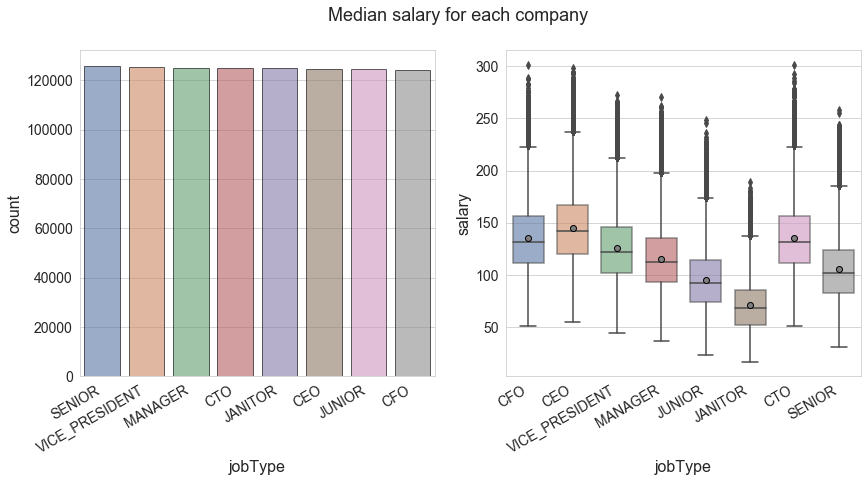

In [23]:
# plot `jobType`
plot_features(train_df, 'jobType')

In [24]:
train_df.groupby(['jobType'])['salary'].agg(['mean', 'count']).reset_index()

,jobType,mean,count
0,CEO,145.311425,124778
1,CFO,135.458547,124369
2,CTO,135.481067,125045
3,JANITOR,70.813045,124971
4,JUNIOR,95.333087,124592
5,MANAGER,115.368518,125120
6,SENIOR,105.487775,125886
7,VICE_PRESIDENT,125.368630,125234


__The dataset is almost uniformly distributed between various job types. CEO, CFO, CTOs have comparatively higher salaries as expected.__

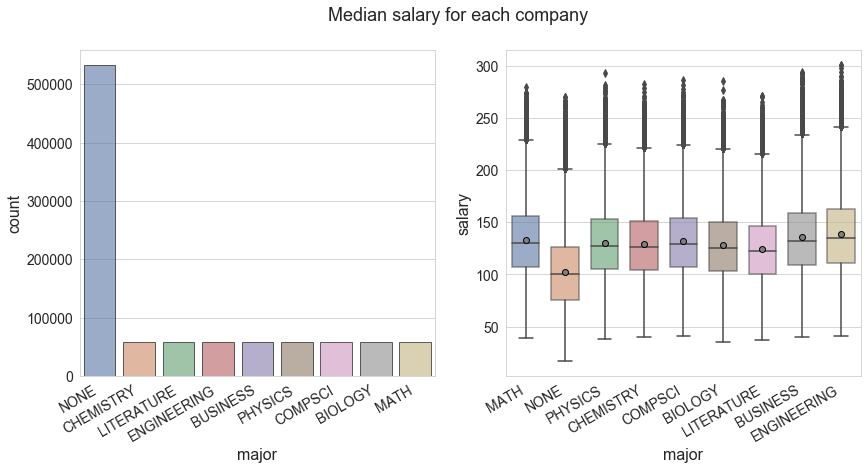

In [25]:
# plot `major`
plot_features(train_df, 'major')

In [26]:
train_df.groupby(['major'])['salary'].agg(['mean', 'count']).reset_index()

,major,mean,count
0,BIOLOGY,127.932664,58379
1,BUSINESS,135.648980,58518
2,CHEMISTRY,129.072085,58875
3,COMPSCI,132.075605,58382
4,ENGINEERING,138.441342,58594
5,LITERATURE,124.423097,58684
6,MATH,133.322042,57800
7,NONE,102.583864,532353
8,PHYSICS,130.372436,58410


__Engineering, Maths, and Business are the majors which get paid more.__

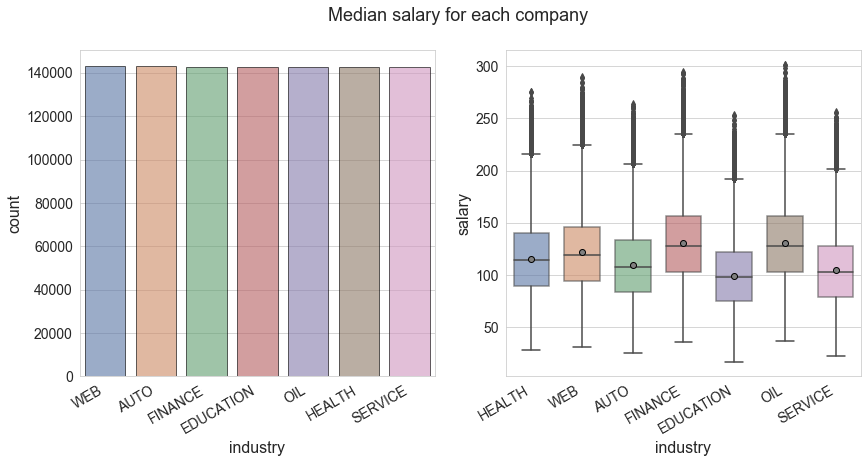

In [27]:
# plot `industry`
plot_features(train_df, 'industry')

In [28]:
train_df.groupby(['industry'])['salary'].agg(['mean', 'count']).reset_index()

,industry,mean,count
0,AUTO,109.435222,142941
1,EDUCATION,99.448386,142819
2,FINANCE,130.747659,142866
3,HEALTH,115.735540,142755
4,OIL,130.953863,142770
5,SERVICE,104.446820,142639
6,WEB,121.645362,143205


__The dataset is also almost uniformly distributed between various industries. Oil and Finance sector pay their employees more salaries as compared to other industries.__

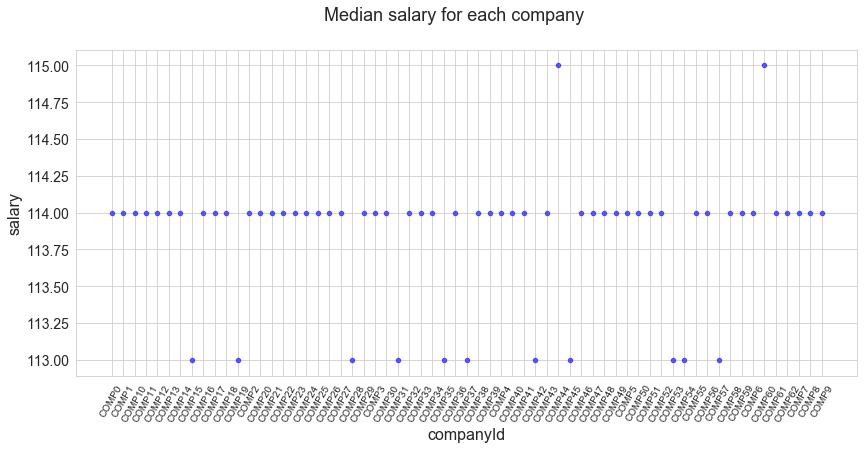

In [29]:
# plot `industry`
plot_features(train_df, 'companyId')

__Most of the companies have almost the same median salary of 114K.__

In [30]:
train_df['meanSalary_per_jobType'] = train_df.groupby('jobType')['salary'].transform('mean')
train_df['meanSalary_per_degree'] = train_df.groupby('degree')['salary'].transform('mean')
train_df['meanSalary_per_industry'] = train_df.groupby('industry')['salary'].transform('mean')
train_df['meanSalary_per_major'] = train_df.groupby('major')['salary'].transform('mean')
train_df['meanSalary_per_company'] = train_df.groupby('companyId')['salary'].transform('mean')
train_df['meanExp_per_degree'] = train_df.groupby('degree')['yearsExperience'].transform('mean')
train_df['meanExp_per_jobType'] = train_df.groupby('jobType')['yearsExperience'].transform('mean')
train_df['meanExp_per_industry'] = train_df.groupby('industry')['yearsExperience'].transform('mean')
train_df['meanExp_per_company'] = train_df.groupby('companyId')['yearsExperience'].transform('mean')
train_df['meanExp_per_major'] = train_df.groupby('major')['yearsExperience'].transform('mean')
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,meanSalary_per_jobType,meanSalary_per_degree,meanSalary_per_industry,meanSalary_per_major,meanSalary_per_company,meanExp_per_degree,meanExp_per_jobType,meanExp_per_industry,meanExp_per_company,meanExp_per_major
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,135.458547,130.505647,115.735540,133.322042,115.345049,11.984987,11.990440,11.972856,11.962905,11.992266
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,145.311425,101.921085,121.645362,102.583864,115.756548,11.995519,11.998269,11.988290,11.882065,11.993151
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,125.368630,135.490979,115.735540,130.372436,116.224249,12.003279,11.993700,11.972856,11.904048,11.984626
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,115.368518,135.490979,109.435222,129.072085,116.199380,12.003279,11.987284,11.974717,12.046906,11.975185
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,125.368630,125.454663,130.747659,130.372436,115.888501,11.986045,11.993700,12.009673,11.968986,11.984626


In [38]:
train_df[train_df['jobId'] == 'JOB1362685398419'][[
    ('meanSalary_per_' + col) for col in ['jobType', 'degree', 'major','industry']
]]

,meanSalary_per_jobType,meanSalary_per_degree,meanSalary_per_major,meanSalary_per_industry
990732,105.487775,101.921085,102.583864,121.645362


In [31]:
train_df['miles_per_yearsExp'] = train_df['milesFromMetropolis'] / train_df['yearsExperience']
inf_idx = train_df['miles_per_yearsExp'][np.isinf(train_df['miles_per_yearsExp'])].index
train_df.loc[inf_idx, 'miles_per_yearsExp'] = train_df.loc[inf_idx, 'milesFromMetropolis']
train_df['miles_per_yearsExpCompanyId'] = train_df.groupby('companyId')['miles_per_yearsExp'].transform('mean')
train_df['miles_per_yearsExpJobType'] = train_df.groupby('jobType')['miles_per_yearsExp'].transform('mean')
train_df['meanMiles_per_company'] = train_df.groupby('companyId')['milesFromMetropolis'].transform('mean')
train_df['meanMiles_per_industry'] = train_df.groupby('industry')['milesFromMetropolis'].transform('mean')
train_df['meanMiles_per_jobType'] = train_df.groupby('jobType')['milesFromMetropolis'].transform('mean')
train_df['meanMiles_per_degree'] = train_df.groupby('degree')['milesFromMetropolis'].transform('mean')
train_df['meanMiles_per_major'] = train_df.groupby('major')['milesFromMetropolis'].transform('mean')
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,meanSalary_per_jobType,...,meanExp_per_company,meanExp_per_major,miles_per_yearsExp,miles_per_yearsExpCompanyId,miles_per_yearsExpJobType,meanMiles_per_company,meanMiles_per_industry,meanMiles_per_jobType,meanMiles_per_degree,meanMiles_per_major
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,135.458547,...,11.962905,11.992266,8.300000,9.359054,9.527343,49.367369,49.501061,49.572715,49.554064,49.423045
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,145.311425,...,11.882065,11.993151,24.333333,9.669803,9.463355,49.505953,49.463315,49.478458,49.459310,49.485358
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,125.368630,...,11.904048,11.984626,3.800000,9.502458,9.460329,49.200292,49.501061,49.428222,49.609020,49.554956
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,115.368518,...,12.046906,11.975185,2.125000,9.540907,9.456207,49.540553,49.553746,49.498354,49.609020,49.553104
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,125.368630,...,11.968986,11.984626,2.000000,9.416518,9.460329,49.624152,49.532940,49.428222,49.589646,49.554956


In [32]:
# Encode all the categorical variables as per the mean of target 
# def mean_encoding(df, col):
#     corr_df = df.copy()
#     cat_means = {}
#     cats = corr_df[col].unique()
#     for cat in cats:
#         cat_means[cat] = corr_df[corr_df[col] == cat]['salary'].mean()
#     corr_df[col] = corr_df[col].map(cat_means)
#     return corr_df

In [33]:
# # Applying the mean encoding to all the categorical columns
# for col in train_df.select_dtypes(['object']).columns.tolist():
#     if col == 'jobId':
#         continue
#     else:
#         train_df_corr = mean_encoding(train_df, col)
# train_df_corr.head()

['yearsExperience', 'milesFromMetropolis', 'salary', 'meanSalary_per_jobType', 'meanSalary_per_degree', 'meanSalary_per_industry', 'meanSalary_per_major', 'meanSalary_per_company', 'meanExp_per_degree', 'meanExp_per_jobType', 'meanExp_per_industry', 'meanExp_per_company', 'meanExp_per_major', 'miles_per_yearsExp', 'miles_per_yearsExpCompanyId', 'miles_per_yearsExpJobType', 'meanMiles_per_company', 'meanMiles_per_industry', 'meanMiles_per_jobType', 'meanMiles_per_degree', 'meanMiles_per_major']


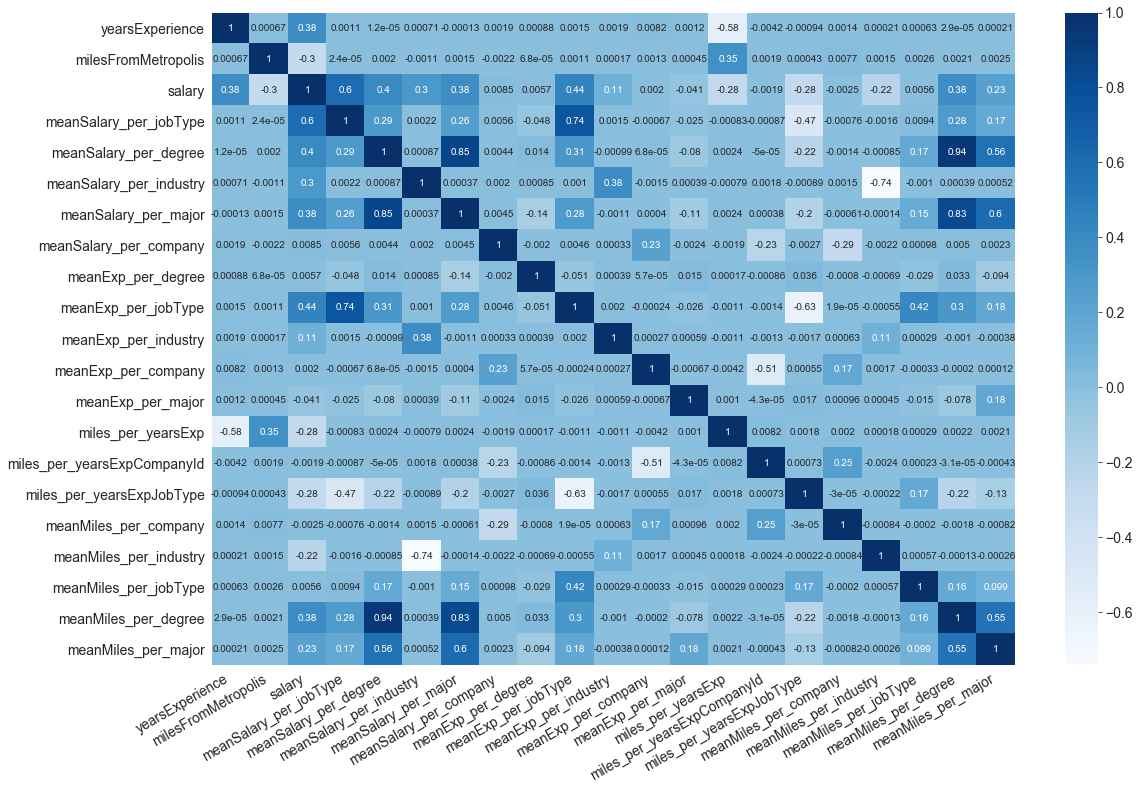

In [37]:
# plotting the correlation between various features and the target
plt.figure(figsize=(18, 12))
# features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
features = [col for col in train_df.columns if (col != 'jobId') and (train_df[col].dtype != 'O')]
print(features)
sns.heatmap(train_df[features].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=30, ha='right')
plt.show()

In [38]:
train_df_corr = train_df[features].corr()
train_df_corr['salary'][(train_df_corr['salary'] > 0.1) | (train_df_corr['salary'] < -0.1)]

yearsExperience              0.375013
milesFromMetropolis         -0.297686
salary                       1.000000
meanSalary_per_jobType       0.597463
meanSalary_per_degree        0.401300
meanSalary_per_industry      0.296626
meanSalary_per_major         0.378675
meanExp_per_jobType          0.443900
meanExp_per_industry         0.112332
miles_per_yearsExp          -0.282846
miles_per_yearsExpJobType   -0.281559
meanMiles_per_industry      -0.219955
meanMiles_per_degree         0.379092
meanMiles_per_major          0.227162
Name: salary, dtype: float64

It looks like `jobType` has the biggest correlation with the target variable `salary`. We can use this to define the baseline model. We can use the mean salary per `jobType` as the salary for the validation data.

### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data